In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, auc, roc_curve, confusion_matrix

from surrogate_functions import get_data_step4, print_evaluation_metrics, plot_most_important_features, plot_odds_ratio, PLTR

In [2]:
X_encoded, y = get_data_step4()

/Users/joaosilva/Current/HEC/Interpretability Stability and Algorithmic Fairness/explainable-credit-scoring/step4/surrogate_functions.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6377609  -0.6377609  -0.6377609  ... -0.6377609  -0.6377609
  1.56798575]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_encoded.loc[:, numerical_existing] = StandardScaler().fit_transform(X_encoded[numerical_existing])
/Users/joaosilva/Current/HEC/Interpretability Stability and Algorithmic Fairness/explainable-credit-scoring/step4/surrogate_functions.py:181: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.84891647 -0.84891647 -1.47571311 ... -1.16231479 -0.53551815
  1.81496925]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  X_encoded.loc[:, numerical_existing] = S

In [3]:
xgb_model = joblib.load('../optimized_xgb_model.pkl')

preds_proba = xgb_model.predict_proba(X_encoded)[:, 1]
preds = (preds_proba >= 0.3).astype(int)

/opt/homebrew/Caskroom/miniforge/base/envs/bike_counters/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:02:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/gbm/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


## Logistic Regression

In [4]:
logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_encoded, preds)
surrogate_preds_proba = logreg.predict_proba(X_encoded)[:, 1] #probs of 1
surrogate_preds = logreg.predict(X_encoded)

### Evaluating the surrogate

In [5]:
print_evaluation_metrics(preds, preds_proba, surrogate_preds, surrogate_preds_proba)

AUC: 0.8312869507312266
Accuracy score: 0.8319186622428275
Confusion matrix: [[477685  85189]
 [ 97387 425975]]
Mean squared error: 0.2849381922522963


### Interpreting the model

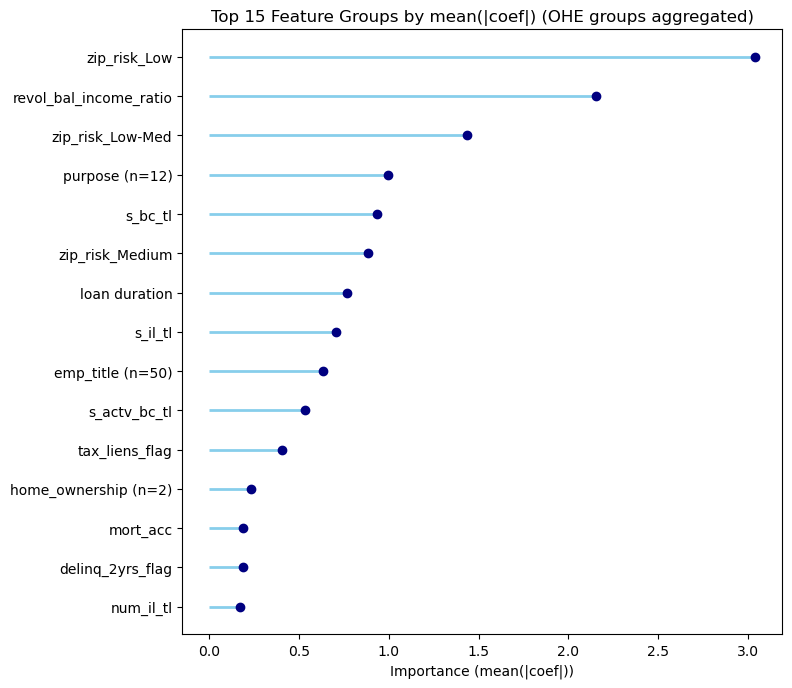

In [6]:
plot_most_important_features(logreg.coef_[0], X_encoded.columns)

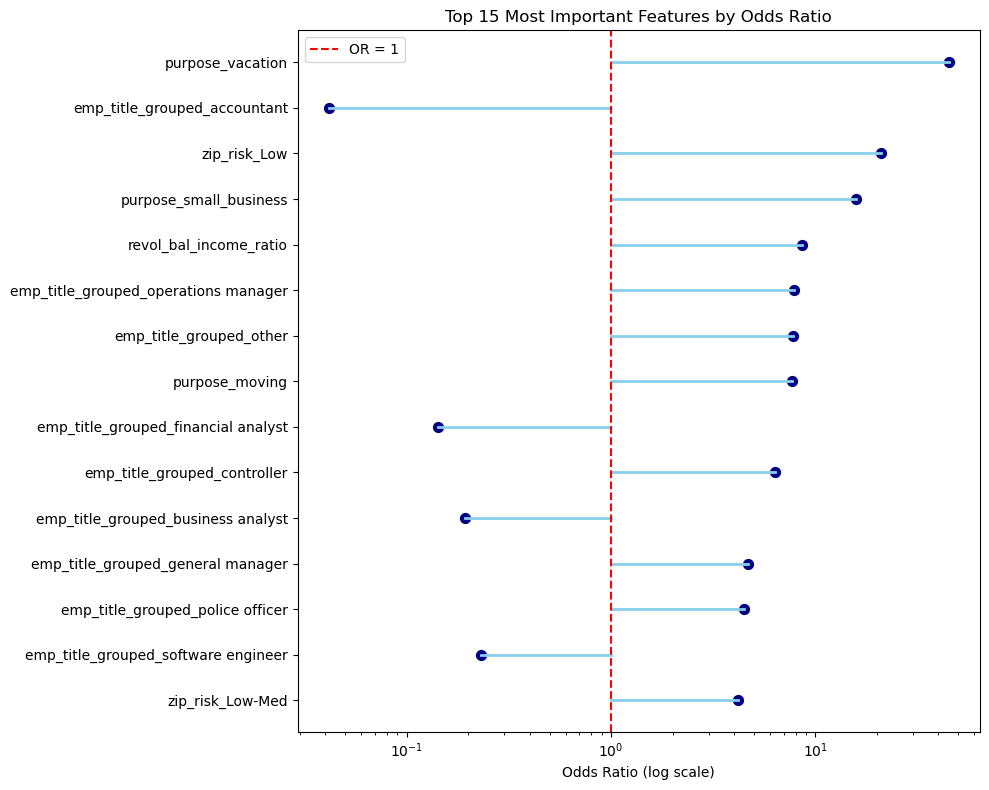

In [7]:
plot_odds_ratio(logreg.coef_[0], X_encoded.columns)

## Custom PLTR

In [8]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=10, feature_names=X_encoded.columns)
pltr.fit(X_encoded, preds, adaptive_lasso=True)

PLTR(feature_names=Index(['loan duration', 'annual_inc', 'bc_open_to_buy', 'bc_util',
       'delinq_2yrs', 'dti', 'fico_range_high', 'funded_amnt',
       'inq_last_6mths', 'int_rate',
       ...
       'emp_title_grouped_sales manager', 'emp_title_grouped_server',
       'emp_title_grouped_software engineer',
       'emp_title_grouped_store manager', 'emp_title_grouped_superintendent',
       'emp_title_grouped_supervisor', 'emp_title_grouped_teacher',
       'emp_title_grouped_technician', 'emp_title_grouped_truck driver',
       'emp_title_grouped_vice president'],
      dtype='object', length=104),
     random_state=10)

In [9]:
pltr.modified_input_full

,loan duration,annual_inc,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,inq_last_6mths,int_rate,...,emp_title_grouped_technician,emp_title_grouped_truck driver,emp_title_grouped_vice president,revol_bal_income_ratio > 0.18,revol_bal_income_ratio < 0.18xzip_risk_Low > 0.5,revol_bal_income_ratio < 0.18xemp_title_grouped_other > 0.5,revol_bal_income_ratio < 0.18xzip_risk_Medium > 0.5,revol_bal_log > 0.28,revol_bal_log < 0.28xemp_title_grouped_other > 0.5,revol_bal_log < 0.28xzip_risk_Low > 0.5
0,-0.667301,-0.063285,0.041421,-0.143576,-0.015752,-0.172496,0.043172,-0.005181,0.029775,-0.031108,...,0.0,0.0,0.0,0.000000,0.000000,0.089495,0.587057,0.00000,0.078761,0.000000
1,-0.667301,-0.039566,0.023043,-0.021951,-0.015752,0.048638,0.025825,0.005182,-0.014194,-0.031108,...,0.0,0.0,0.0,4.814649,0.000000,0.000000,0.000000,0.14808,0.000000,0.000000
2,-0.667301,0.337778,0.013758,0.020522,-0.015752,0.001764,0.036233,0.005625,0.007791,-0.067737,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.14808,0.000000,0.000000
3,-0.667301,0.075948,-0.023548,0.103857,-0.015752,-0.058132,0.015417,-0.001827,0.007791,-0.020239,...,0.0,0.0,0.0,0.000000,0.000000,0.089495,0.000000,0.00000,0.078761,0.000000
4,1.640611,-0.011843,-0.018905,0.044975,0.031019,0.051459,-0.019277,0.005439,0.007791,0.066496,...,0.0,0.0,0.0,4.814649,0.000000,0.000000,0.000000,0.14808,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086231,1.640611,0.029742,0.032302,-0.149689,-0.015752,-0.109238,-0.005399,0.008885,0.007791,0.001499,...,0.0,0.0,0.0,0.000000,0.236765,0.089495,0.000000,0.00000,0.078761,0.023635
1086232,1.640611,0.040524,0.038876,-0.111722,0.124561,-0.073105,-0.015808,0.003762,0.007791,0.110189,...,0.0,0.0,0.0,0.000000,0.236765,0.089495,0.000000,0.00000,0.078761,0.023635
1086233,-0.667301,-0.024164,0.058262,-0.116226,0.031019,0.012614,0.022356,-0.002759,-0.014194,-0.063715,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.587057,0.00000,0.000000,0.000000
1086234,-0.667301,-0.061128,-0.008805,-0.177682,0.031019,0.017388,-0.015808,-0.004622,-0.014194,-0.026217,...,0.0,0.0,0.0,0.000000,0.000000,0.089495,0.000000,0.00000,0.078761,0.000000


In [10]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [11]:
print_evaluation_metrics(preds, preds_proba, pltr_pred, pltr_pred_prob)

AUC: 0.8720158056765541
Accuracy score: 0.8723509439937546
Confusion matrix: [[496021  66853]
 [ 71804 451558]]
Mean squared error: 0.30842523197768656


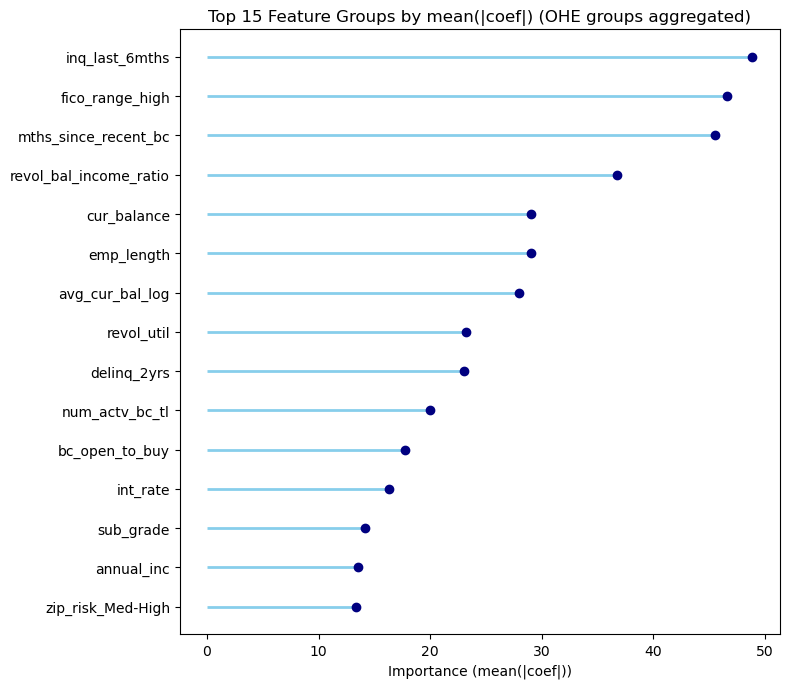

In [12]:
plot_most_important_features(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)

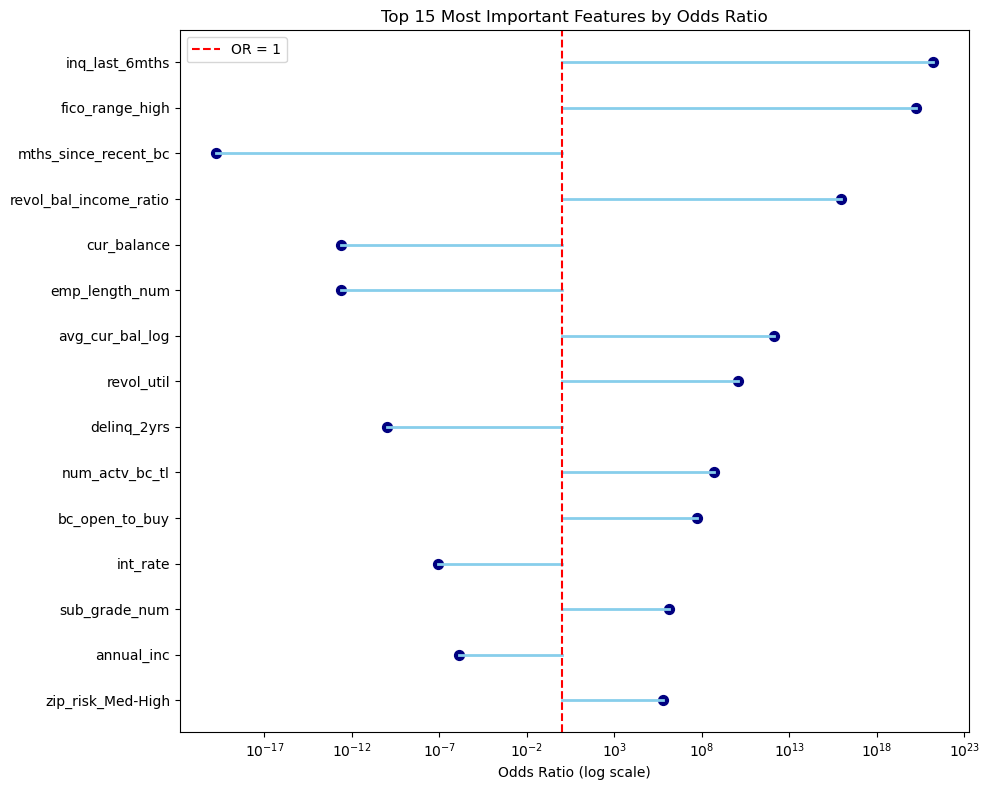

In [13]:
plot_odds_ratio(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)